In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética para gráficos académicos (estilo TFG)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'serif' # Da un toque más formal/académico

# 1. CARGA DE DATOS
# ------------------------------------------------------
# Ajusta la ruta si tu libreta no está en la raíz, pero según tu estructura esto debería funcionar
try:
    df_detail = pd.read_csv('results/detailed_predictions.csv')
    df_metrics = pd.read_csv('results/summary_metrics.csv')
    print("✅ Datos cargados correctamente.")
    print(f"Modelos disponibles: {df_detail['Model'].unique()}")
except FileNotFoundError:
    print("❌ Error: No se encuentran los archivos CSV en la carpeta 'results/'. Verifica la ruta.")

# Convertir fecha a datetime
df_detail['Date'] = pd.to_datetime(df_detail['Date'])

# ------------------------------------------------------
# BLOQUE 1: ANÁLISIS DE NEGOCIO (EL "FACTOR MATRÍCULA")
# Curva de Equidad: ¿Cuánto dinero ganaría cada modelo?
# ------------------------------------------------------

def plot_equity_curve(dataset_name):
    # Filtrar por dataset
    data = df_detail[df_detail['Dataset'] == dataset_name].copy()
    
    # Ordenar por fecha
    data = data.sort_values(by='Date')
    
    plt.figure(figsize=(14, 7))
    
    # Lista de modelos a destacar (incluyendo TimeGPT como pediste)
    models_to_plot = ['arima', 'timegpt', 'chronos', 'llama3_local']
    
    for model in data['Model'].unique():
        # Si quieres limpiar el gráfico, descomenta la siguiente línea para mostrar solo los importantes
        # if model not in models_to_plot: continue
        
        model_data = data[data['Model'] == model]
        
        # Calcular Retorno Acumulado (Equity Curve)
        # Asumiendo inversión inicial de 100€
        # Strategy_Return_Pct es el retorno del periodo. Acumulado = Producto de (1 + r)
        equity = 100 * (1 + model_data['Strategy_Return_Pct'] / 100).cumprod()
        
        # Estilos diferenciados
        if model == 'timegpt':
            plt.plot(model_data['Date'], equity, label=f"{model} (Foundation)", linewidth=2.5, linestyle='-')
        elif model == 'llama3_local':
            plt.plot(model_data['Date'], equity, label=f"{model} (LLM)", linewidth=2.5, color='purple')
        elif model == 'arima':
            plt.plot(model_data['Date'], equity, label=f"{model} (Baseline)", linewidth=2, linestyle='--', color='gray')
        else:
            plt.plot(model_data['Date'], equity, label=model, alpha=0.6)

    plt.title(f'Curva de Equidad: Inversión de 100€ en {dataset_name}', fontsize=16)
    plt.xlabel('Fecha')
    plt.ylabel('Valor de la Cartera (€)')
    plt.legend()
    plt.show()

# EJEMPLO: Ejecutar para Bitcoin y SP500
# plot_equity_curve('BTC_Monthly')
# plot_equity_curve('SP500_Monthly')

# ------------------------------------------------------
# BLOQUE 2: COMPARATIVA TÉCNICA (HEATMAP)
# Resumen visual de precisión para el tribunal
# ------------------------------------------------------

def plot_heatmap_mape():
    # Pivotar datos: Filas=Modelos, Columnas=Datasets, Valores=MAPE
    heatmap_data = df_metrics.pivot(index='Model', columns='Dataset', values='MAPE')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn_r', fmt=".2f", linewidths=.5)
    plt.title('Mapa de Calor de Error (MAPE %)\nVerde = Mejor, Rojo = Peor', fontsize=16)
    plt.ylabel('Modelo')
    plt.xlabel('Activo Financiero')
    plt.show()

# plot_heatmap_mape()

# ------------------------------------------------------
# BLOQUE 3: EFICIENCIA (SCATTER PLOT)
# Coste Computacional vs. Precisión
# ------------------------------------------------------

def plot_efficiency_frontier():
    plt.figure(figsize=(10, 6))
    
    # Usamos scatterplot de seaborn
    sns.scatterplot(
        data=df_metrics, 
        x='inference_time', 
        y='MAPE', 
        hue='Type', 
        style='Model', 
        s=150 # Tamaño de puntos
    )
    
    plt.xscale('log') # Escala logarítmica porque los LLMs son mucho más lentos
    plt.title('Frontera de Eficiencia: Tiempo de Inferencia vs. Error', fontsize=16)
    plt.xlabel('Tiempo de Inferencia (segundos) [Escala Log]')
    plt.ylabel('Error (MAPE %)')
    plt.grid(True, which="both", ls="--")
    
    # Anotaciones para destacar TimeGPT o Llama
    # (Opcional: añadir etiquetas de texto a los puntos más relevantes)
    
    plt.show()

# plot_efficiency_frontier()

# ------------------------------------------------------
# BLOQUE 4: ANÁLISIS REAL vs PREDICCIÓN (ZOOM)
# Ver si el LLM "alucina"
# ------------------------------------------------------

def plot_forecast_vs_actual(dataset_name, date_start=None):
    data = df_detail[df_detail['Dataset'] == dataset_name]
    
    if date_start:
        data = data[data['Date'] >= date_start]
        
    plt.figure(figsize=(14, 6))
    
    # Pintar Realidad (solo una vez)
    one_model = data['Model'].unique()[0]
    real_data = data[data['Model'] == one_model]
    plt.plot(real_data['Date'], real_data['y_true'], 'k-', label='REAL', linewidth=3, alpha=0.8)
    
    # Pintar Modelos
    focus_models = ['arima', 'timegpt', 'llama3_local']
    for model in focus_models:
        if model in data['Model'].unique():
            model_subset = data[data['Model'] == model]
            plt.plot(model_subset['Date'], model_subset['y_pred'], label=f'Pred: {model}', linestyle='--')
            
    plt.title(f'Predicción vs Realidad: {dataset_name}', fontsize=16)
    plt.legend()
    plt.show()

# plot_forecast_vs_actual('BTC_Daily', '2024-01-01')

✅ Datos cargados correctamente.
Modelos disponibles: ['arima' 'ses' 'holt' 'holt_winters' 'timegpt' 'moirai' 'chronos'
 'llama3_local']


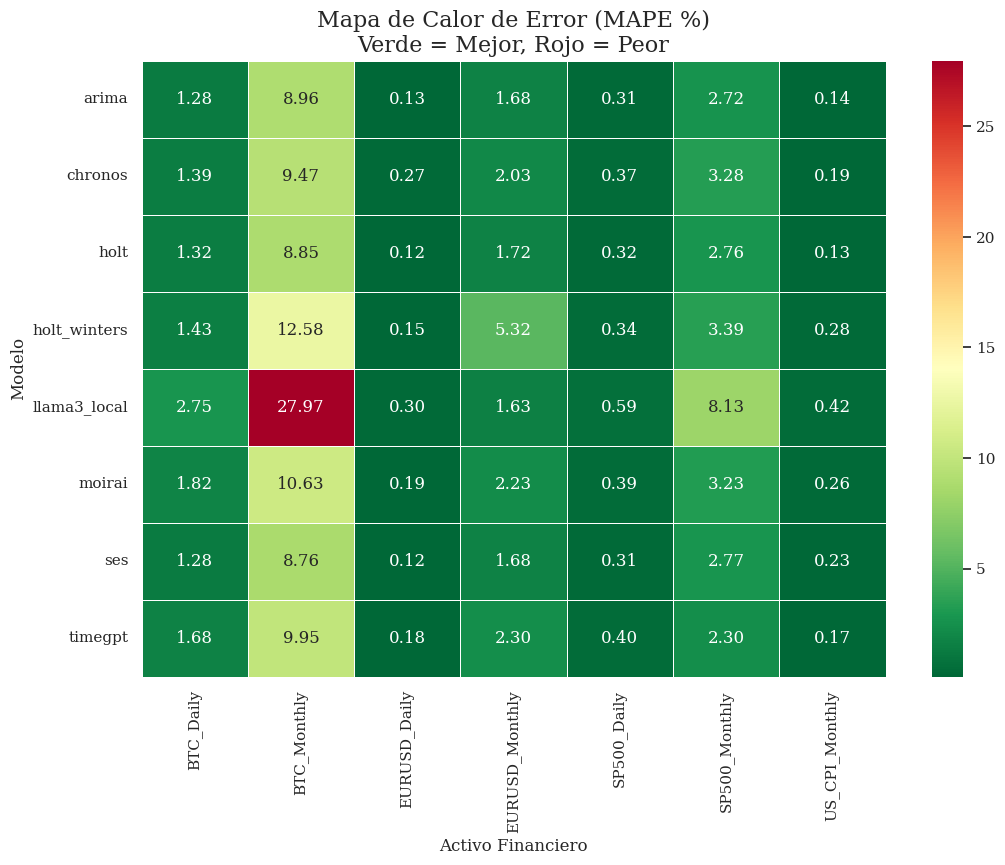

In [2]:
plot_heatmap_mape()

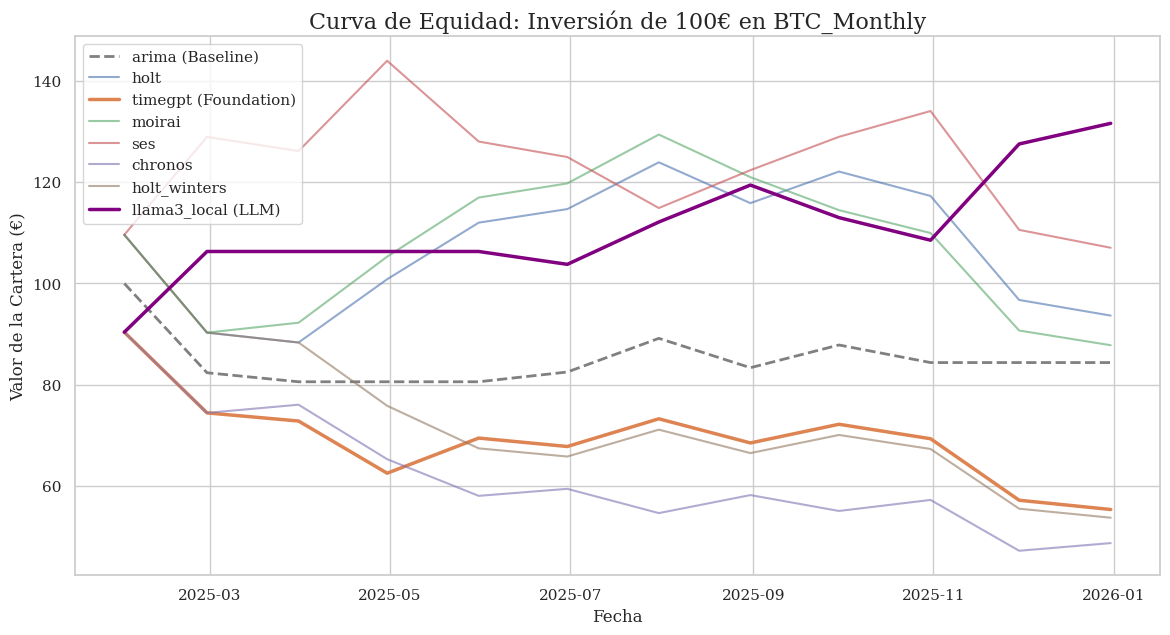

In [3]:
plot_equity_curve('BTC_Monthly')

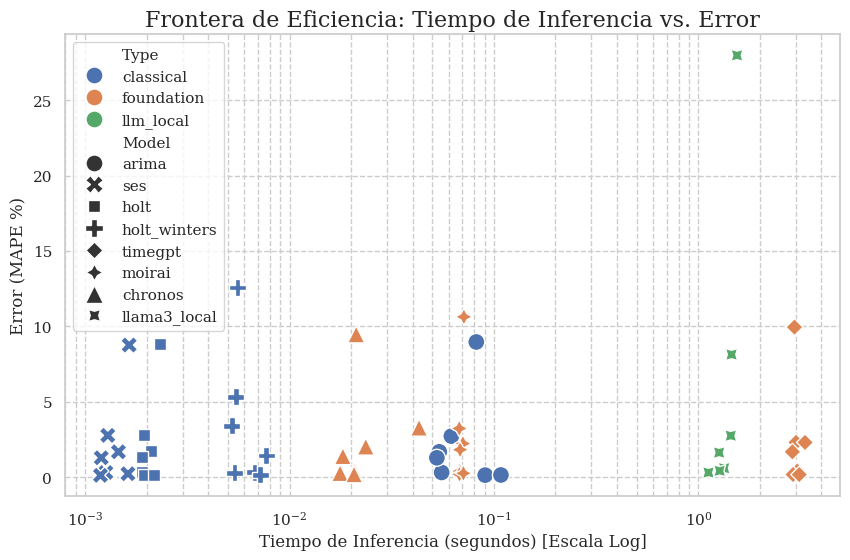

In [4]:
plot_efficiency_frontier()